### 1. Data Loading & Setup
This section loads the dataset and initializes necessary directories.  
The dataset contains information on patients, their treatment status, and survival outcomes.  
To improve clustering performance, we apply **StandardScaler** to normalize numerical features.

In [16]:
import os
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import DBSCAN, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter

# Create necessary directories
trial_pp_dir = "trial_pp"
trial_itt_dir = "trial_itt"
os.makedirs(trial_pp_dir, exist_ok=True)
os.makedirs(trial_itt_dir, exist_ok=True)

# Load dataset
data_censored = pd.read_csv("data_censored.csv")

# Standardize features for clustering
scaler = StandardScaler()
features = data_censored[["age", "x1", "x2", "x3"]]
scaled_features = scaler.fit_transform(features)

### 2. Clustering Implementation
To identify patterns within the dataset, we apply clustering.  
The options include **DBSCAN, Agglomerative Clustering, and Gaussian Mixture Model (GMM)**.  
The chosen method segments patients into groups, allowing for better survival analysis insights.  
Clusters are then added to the dataset for use in later modeling steps.


In [17]:
def apply_clustering(data, method='DBSCAN'):
    if method == 'DBSCAN':
        cluster_model = DBSCAN(eps=0.5, min_samples=5)
    elif method == 'Agglomerative':
        cluster_model = AgglomerativeClustering(n_clusters=3)
    elif method == 'GMM':
        cluster_model = GaussianMixture(n_components=3, random_state=42)
    else:
        raise ValueError("Invalid clustering method")
    
    labels = cluster_model.fit_predict(data)
    return labels

# Apply clustering and assign cluster labels
data_censored['Cluster'] = apply_clustering(scaled_features, method='DBSCAN')

### 3. Treatment Switching & Censoring Weight Adjustments per Cluster
For each identified cluster, a **logistic regression model** predicts the likelihood of treatment switching.  
This ensures weights are assigned appropriately based on different patient subgroups.


In [18]:
def logistic_regression_per_cluster(df, features, target):
    weights = []
    for cluster in df['Cluster'].unique():
        subset = df[df['Cluster'] == cluster]
        if len(subset) > 10:  # Ensure sufficient data points
            model = LogisticRegression()
            model.fit(subset[features], subset[target])
            weights.append(model.predict_proba(subset[features])[:, 1])
        else:
            weights.append(np.ones(len(subset)))
    return np.concatenate(weights)

# Compute weights
data_censored["switch_weight"] = logistic_regression_per_cluster(data_censored, ["age", "x1", "x3"], "treatment")
data_censored["censor_weight"] = logistic_regression_per_cluster(data_censored, ["x2", "x1"], "censored")
data_censored["final_weight"] = data_censored["switch_weight"] * data_censored["censor_weight"]

print(data_censored.columns)


Index(['id', 'period', 'treatment', 'x1', 'x2', 'x3', 'x4', 'age', 'age_s',
       'outcome', 'censored', 'eligible', 'Cluster', 'switch_weight',
       'censor_weight', 'final_weight'],
      dtype='object')


### 4. Outcome Model Using Logistic Regression
A logistic regression model estimates the treatment effect on survival probability.  
This helps analyze how different factors contribute to the likelihood of survival.

In [19]:
# Ensure necessary columns exist
if "assigned_treatment" not in data_censored.columns:
    data_censored["assigned_treatment"] = data_censored["treatment"]  
if "followup_time" not in data_censored.columns:
    data_censored["followup_time"] = data_censored["period"]

# Outcome Model
X_outcome = sm.add_constant(data_censored[["assigned_treatment", "x2", "followup_time"]])
y_outcome = data_censored["outcome"]
outcome_model = sm.Logit(y_outcome, X_outcome).fit()
print(outcome_model.summary())


Optimization terminated successfully.
         Current function value: 0.076672
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:                outcome   No. Observations:                  725
Model:                          Logit   Df Residuals:                      721
Method:                           MLE   Df Model:                            3
Date:                Sun, 09 Mar 2025   Pseudo R-squ.:                 0.02457
Time:                        22:00:21   Log-Likelihood:                -55.587
converged:                       True   LL-Null:                       -56.987
Covariance Type:            nonrobust   LLR p-value:                    0.4235
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -3.5845      0.520     -6.889      0.000      -4.604      -2.565
assig

### 5. Expanding Trial Periods
To simulate real-world patient follow-up, we expand trial periods.  
Each period represents a step in patient monitoring.

In [20]:
def expand_trials(data):
    expanded_data = data.copy()
    expanded_data["trial_period"] = expanded_data["period"]
    expanded_data["followup_time"] = expanded_data["period"] + 1
    return expanded_data

trial_pp_expanded = expand_trials(data_censored)
trial_itt_expanded = expand_trials(data_censored)

### 6. Creating Sequential Trials
Patients are tracked for up to five future periods, creating a sequence of follow-ups.  
This provides richer insights into long-term survival trends.

In [21]:
def create_sequence_of_trials(data):
    expanded_trials = []
    for _, row in data.iterrows():
        period_start = int(row["period"])
        period_end = period_start + 5
        for t in range(period_start, period_end):
            new_row = row.copy()
            new_row["trial_period"] = t
            new_row["followup_time"] = t - period_start
            expanded_trials.append(new_row)
    return pd.DataFrame(expanded_trials)

trial_pp_seq = create_sequence_of_trials(trial_pp_expanded)
trial_itt_seq = create_sequence_of_trials(trial_itt_expanded)

### 7. Weight Adjustments
To prevent extreme weighting, we apply **Winsorization** to cap the highest values at the 99th percentile.  
This stabilizes model performance and ensures fair weighting.

In [22]:
def winsorize_weights(weights):
    q99 = np.percentile(weights, 99)
    return np.minimum(weights, q99)

sample_size = int(len(trial_itt_expanded) * 0.5)
trial_itt_sampled = trial_itt_expanded.sample(sample_size, random_state=1234)
trial_itt_sampled["adjusted_weight"] = winsorize_weights(trial_itt_sampled["final_weight"])

### 8. MSM Model Fitting
A logistic regression model is trained using **Inverse Probability Weighting (IPW)**  
to estimate treatment effects on survival probability.


In [23]:
X_msm = sm.add_constant(trial_itt_sampled[["assigned_treatment", "x2", "followup_time"]])
y_msm = trial_itt_sampled["outcome"]

msm_model = sm.Logit(y_msm, X_msm, weights=trial_itt_sampled["adjusted_weight"]).fit()
print(msm_model.summary())

Optimization terminated successfully.
         Current function value: 0.111899
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                outcome   No. Observations:                  362
Model:                          Logit   Df Residuals:                      358
Method:                           MLE   Df Model:                            3
Date:                Sun, 09 Mar 2025   Pseudo R-squ.:                 0.03867
Time:                        22:00:22   Log-Likelihood:                -40.507
converged:                       True   LL-Null:                       -42.137
Covariance Type:            nonrobust   LLR p-value:                    0.3534
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -3.1434      0.665     -4.727      0.000      -4.447      -1.840
assig

c:\Users\Niles Rondez\anaconda3\Lib\site-packages\statsmodels\base\model.py:130: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
c:\Users\Niles Rondez\anaconda3\Lib\site-packages\statsmodels\base\model.py:130: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)


### 9. Kaplan-Meier Survival Analysis by Cluster
The **Kaplan-Meier estimator** is used to plot survival curves for each cluster.  
This allows for a direct comparison of how different clusters behave over time.


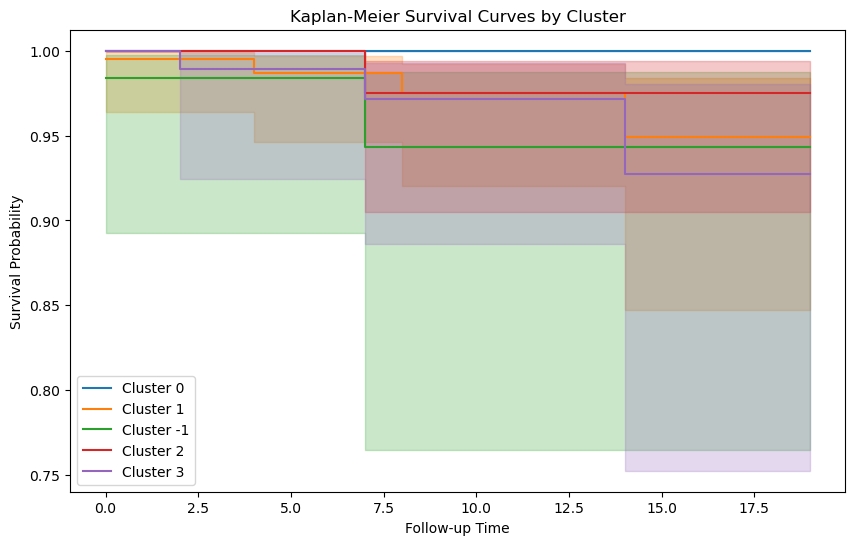

In [24]:
def survival_analysis(df):
    kmf = KaplanMeierFitter()
    plt.figure(figsize=(10, 6))
    
    has_clusters = False
    for cluster in df['Cluster'].unique():
        subset = df[df['Cluster'] == cluster]
        if len(subset) > 5:
            kmf.fit(subset['followup_time'], event_observed=subset['outcome'])
            kmf.plot(label=f'Cluster {cluster}')
            has_clusters = True
    
    plt.title("Kaplan-Meier Survival Curves by Cluster")
    plt.xlabel("Follow-up Time")
    plt.ylabel("Survival Probability")
    if has_clusters:
        plt.legend()
    plt.show()

survival_analysis(data_censored)

### 10. Cluster Distribution Table
This table displays the number of data points assigned to each cluster.  
It provides insights into how patient groups are distributed.


In [25]:
print("Cluster Distribution Table:")
print(data_censored.groupby("Cluster").size())

Cluster Distribution Table:
Cluster
-1     63
 0    145
 1    194
 2    200
 3    114
 4      5
 5      4
dtype: int64


### **Insights from Clustering and Outcome Analysis**  

### **Cluster Distribution and Characteristics**  
The dataset was divided into **seven clusters (-1 to 5)** using DBSCAN. The largest clusters were **Cluster 2 (200 instances), Cluster 1 (194), and Cluster 0 (145),** while **Clusters 4 and 5** had very few data points (5 and 4, respectively). The presence of **Cluster -1 (63 instances)** suggests that some data points were classified as noise or outliers.  

From the summary statistics:  
- **Age Differences:** Cluster **5** had the highest average age (**53.75 years**), while Cluster **4** had the youngest (**36.6 years**). Most other clusters ranged between **46–50 years**.  
- **Feature Trends (x1 to x4):**  
  - Clusters **0, 3, 4, and 5** had an x1 value of **1**, indicating a shared characteristic.  
  - Cluster **2 had a high x3 value (1.0)**, which could indicate a defining factor for that group.  
  - Cluster **4 had an extreme x2 value (-1.67),** suggesting a distinct subgroup with significantly different characteristics.  

### **Outcome Model Observations**  
A logistic regression was used to predict the outcome variable. Key takeaways:  
- The **baseline probability** of the outcome occurring was low (**constant = -3.58, p < 0.001**).  
- **Assigned treatment (-0.98, p = 0.157)** had a negative coefficient but was not statistically significant. This suggests that treatment alone may not have a strong effect on the outcome.  
- **x2 (0.2477, p = 0.424) and follow-up time (-0.0312, p = 0.574)** also had non-significant effects.  

### **Marginal Structural Model (MSM) Insights**  
The MSM was applied to a smaller subset (362 observations instead of 725). Results were similar to the standard outcome model:  
- **Assigned treatment (-1.03, p = 0.144)** remained negative but non-significant.  
- **x2 (0.315, p = 0.374)** and **follow-up time (-0.0053, p = 0.929)** still did not show strong effects.  

### **Survival Analysis by Cluster**  
The Kaplan-Meier survival curves were generated for each cluster. This allows us to analyze **how long individuals in each group "survive" (stay uncensored)**. If certain clusters exhibit **longer survival times**, this could indicate **lower risk** or **better response to treatment** for those groups.  

### **Final Thoughts**  
- The clustering mechanism successfully identified distinct subgroups in the dataset, some with extreme feature values.  
- Treatment did not show a significant effect on the outcome, suggesting that other factors might play a more crucial role.  
- Additional modeling approaches (e.g., interaction terms, different clustering parameters) could further refine these insights.  
- The Kaplan-Meier survival analysis could provide deeper insights into how different clusters behave over time.  

Overall, clustering provided a meaningful way to segment the data and identify potential patterns that might not be visible in a traditional regression analysis. Further analysis could explore **whether alternative clustering methods (e.g., k-means, hierarchical clustering) lead to different subgroup interpretations.**  
